#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [450]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge, Lasso
warnings.filterwarnings("ignore")

In [451]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv(r'C:\Users\Barbos-Rapitos\Desktop\practicum\time_series\taxi.csv')

## Анализ

In [452]:
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [453]:
data.datetime = pd.to_datetime(data.datetime)

In [454]:
data = data.set_index('datetime')

In [455]:
data.index.is_monotonic

True

Text(0.5, 0, '')

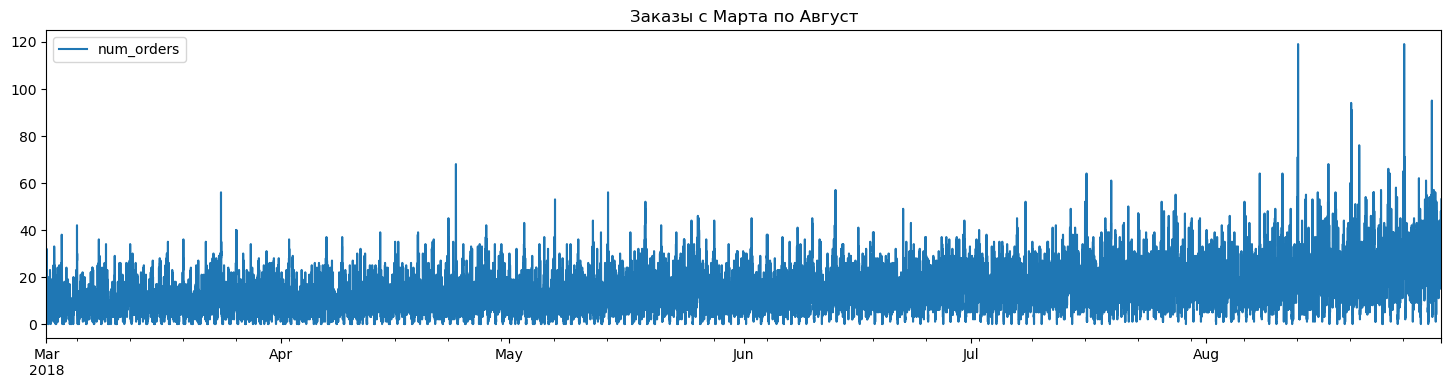

In [456]:
plt.rcParams['figure.figsize'] = (18,4)
data.plot()
plt.title('Заказы с Марта по Август')
plt.xlabel(None)

Text(0.5, 0, '')

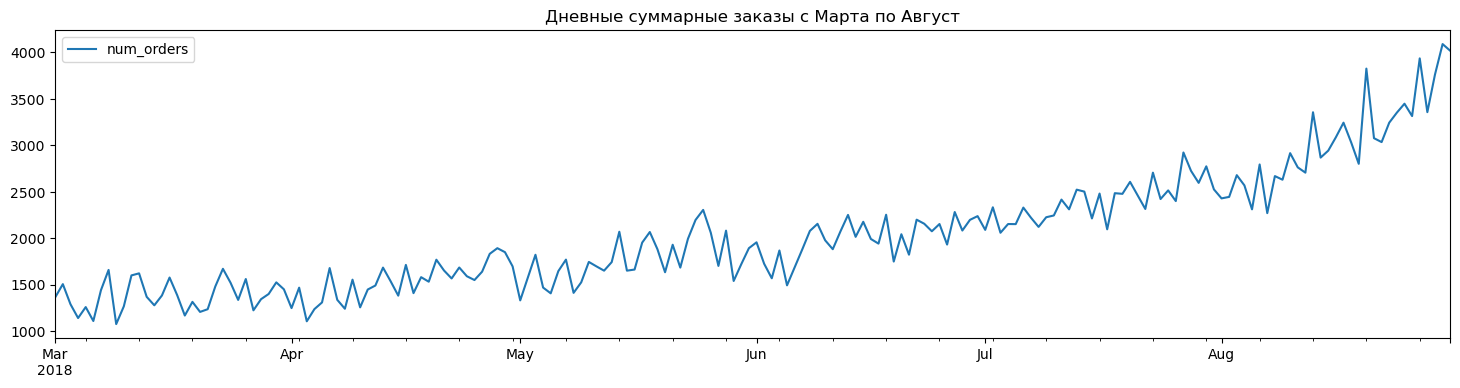

In [457]:
data.resample('1D').sum().plot()
plt.title('Дневные суммарные заказы с Марта по Август')
plt.xlabel(None)

Text(0.5, 0, '')

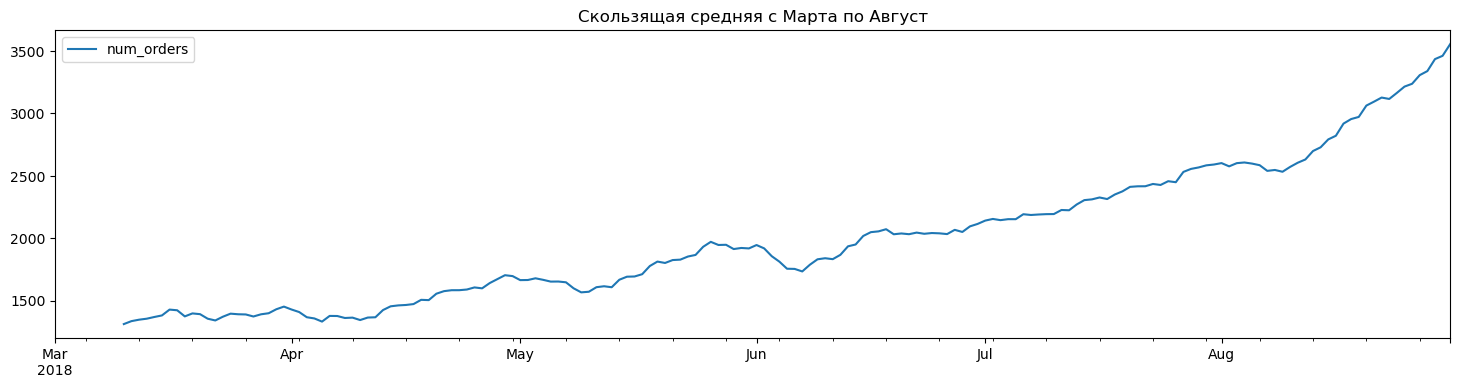

In [458]:
data.resample('1D').sum().rolling(10).mean().plot()
plt.title('Скользящая средняя с Марта по Август')
plt.xlabel(None)

Text(0.5, 0, '')

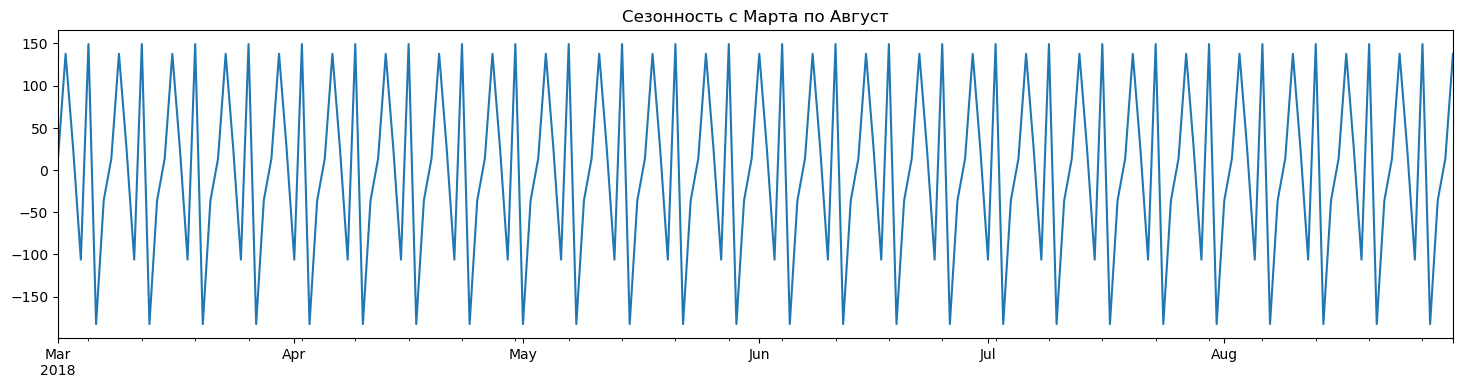

In [459]:

decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность с Марта по Август')
plt.xlabel(None)

Text(0.5, 0, '')

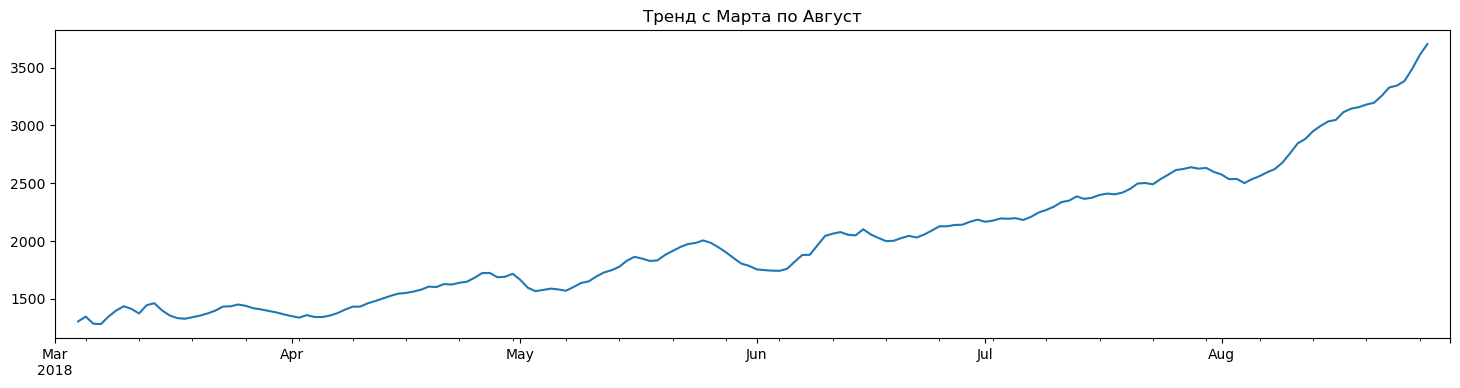

In [460]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд с Марта по Август')
plt.xlabel(None)

Text(0.5, 0, '')

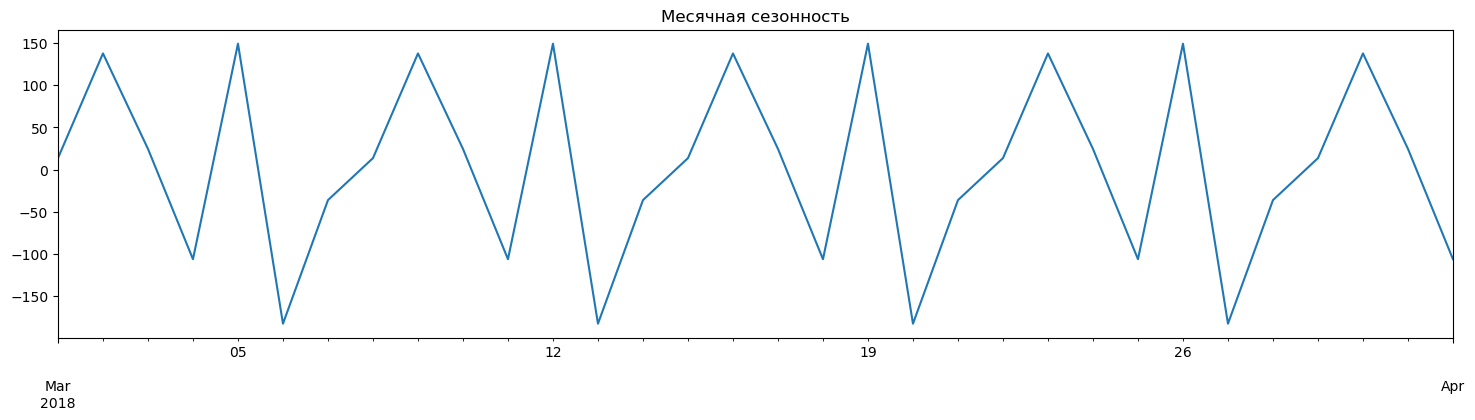

In [461]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Месячная сезонность')
plt.xlabel(None)

Text(0.5, 0, '')

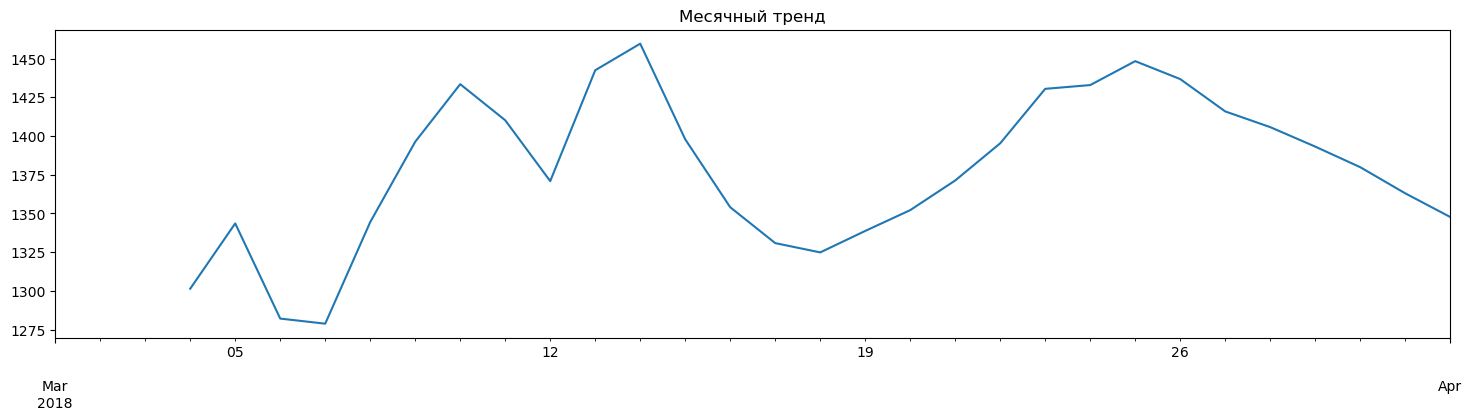

In [462]:
decomposed.trend['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Месячный тренд')
plt.xlabel(None)

Text(0.5, 0, '')

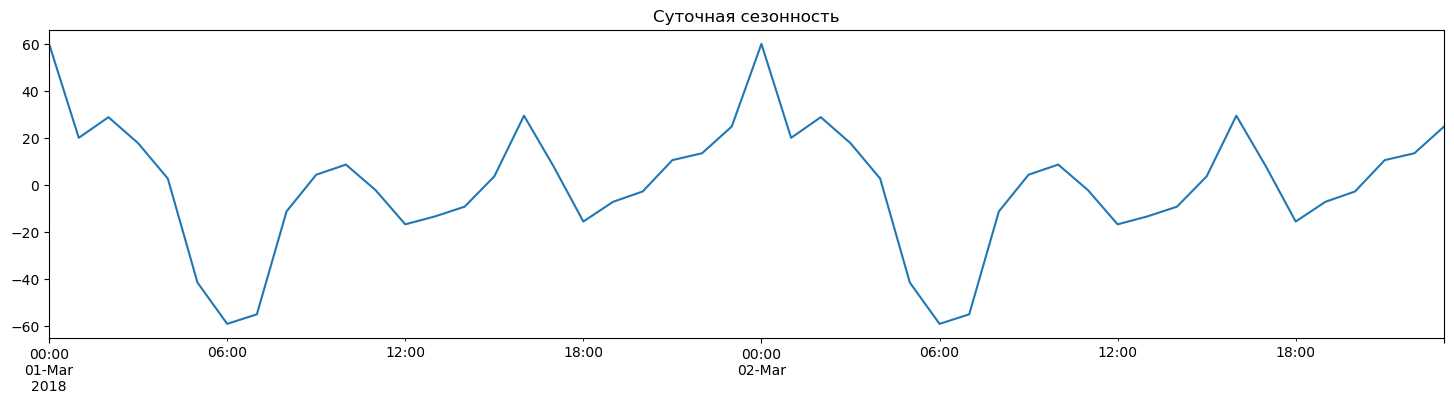

In [463]:
decomposed = seasonal_decompose(data.resample('1H').sum())
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Суточная сезонность')
plt.xlabel(None)

Text(0.5, 0, '')

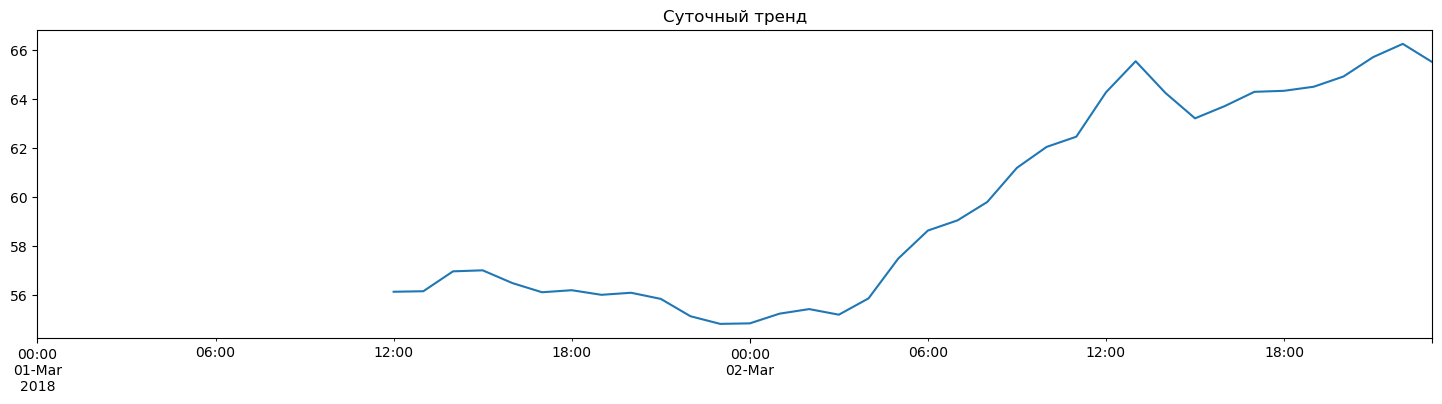

In [464]:
decomposed.trend['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Суточный тренд')
plt.xlabel(None)

Text(0.5, 0, '')

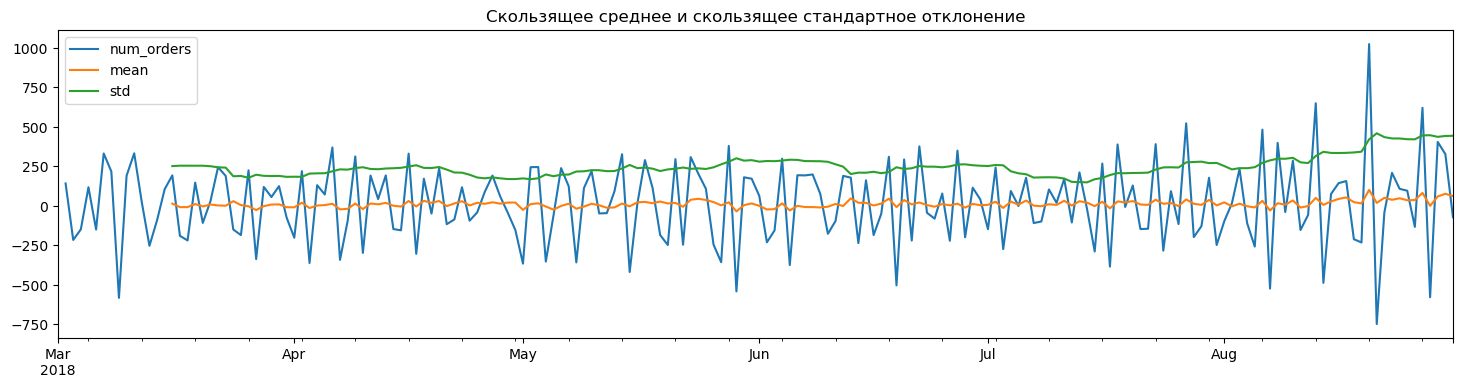

In [465]:
data_time_series_difference = data.copy().resample('1D').sum()
data_time_series_difference = data_time_series_difference - data_time_series_difference.shift()
data_time_series_difference['mean'] = data_time_series_difference['num_orders'].rolling(15).mean()
data_time_series_difference['std'] = data_time_series_difference['num_orders'].rolling(15).std()
data_time_series_difference.plot()
plt.title('Скользящее среднее и скользящее стандартное отклонение')
plt.xlabel(None)

In [466]:
data.isna().sum()

num_orders    0
dtype: int64

In [467]:
data = data.resample('1H').sum()

In [468]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [469]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Функция ниже создает новые признаки (features) на основе исходного датафрейма df.

Сначала функция выполняет копирование исходного датафрейма, чтобы не изменять его напрямую. Затем создаются новые столбцы 'year', 'month', 'day' и 'dayofweek', которые содержат информацию о годе, месяце, дне и дне недели соответственно. Это позволяет использовать временные компоненты как признаки для модели.

Далее, в цикле от 1 до max_lag, функция создает новые столбцы 'lag_X', где X - это значение от 1 до max_lag. Каждый столбец 'lag_X' содержит значение 'num_orders' (предполагаемо, это количество заказов) сдвинутое на X шагов назад. Это позволяет модели учитывать предыдущие значения признака в предсказании будущих значений.

Также внутри цикла функция создает столбец 'rolling_mean', который представляет скользящее среднее значение 'num_orders' с предыдущего шага, рассчитываемое на основе rolling_mean_size (размер окна скользящего среднего).

Наконец, функция возвращает измененный датафрейм df с новыми признаками. 

In [470]:
#функцция создания фичей
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df

Это делается для добавления дополнительной информации в исходный датафрейм, которая может быть полезной при обучении модели машинного обучения.

Создание новых признаков, таких как год, месяц, день и день недели, позволяет модели учитывать сезонные или периодические паттерны в данных. Например, определенный месяц или день недели может иметь влияние на количество заказов, и модель сможет учесть эту зависимость.

Создание признаков lag_X позволяет модели использовать информацию о предыдущих значениях целевой переменной (количество заказов) при предсказании будущих значений. Это особенно полезно, если есть тенденция или зависимость от предыдущих значений, которую модель может использовать для более точного прогнозирования.

Столбец 'rolling_mean' предоставляет информацию о сглаженном среднем значении 'num_orders' на предыдущих шагах. Это может помочь модели учесть общую тенденцию или тренд изменения количества заказов.

В целом, добавление этих признаков позволяет модели уловить более сложные зависимости и улучшить ее способность прогнозировать будущие значения на основе доступных данных. 

In [471]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Обучение и тестирование

In [472]:
data = make_features(data, 200, 5)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders',axis=1)
train_target = train.num_orders

test_features = test.drop('num_orders', axis=1)
test_target = test.num_orders

Разделили данные на выборки, количесво лагов сделали равным 200, скользящее среднее 5

In [473]:
#define evaluation
cv = TimeSeriesSplit(n_splits=5)

In [474]:
lgbm = lgb.LGBMRegressor(objective ='regression',
                         metric = 'mae',
                         random_state = 12345)

#Функция расчета RMSE
def rmse (target, predictions):
    result = mean_squared_error(target,predictions)**0.5
    return result

rmse_scorer = make_scorer(rmse, greater_is_better=False)

#USING GRID SEARCH
params_lgbm = {
    # The maximum number of leaves per tree; higher num_leaves means less conservative/control, potentially overfitting (default is 31)
    'num_leaves':[10,],
    # Lower means longer to train but more accurate # Should not interfere with overfitting (default is 0.1)
    'learning_rate':[0.06552619413921881],
    # The more trees the less likely the algorithm is to overfit. So try increasing the number of estimators. (default is 100)
    'n_estimators':[95, 100, 105,],
    # The ratio of features used (i.e. columns used); colsample_bytree. Lower ratios avoid over-fitting. (default is 1.0)
    'colsample_bytree': [0.51],
    # The ratio of the training instances used (i.e. rows used); subsample. Lower ratios avoid over-fitting. (default is 1.0)
    'subsample': [0.6633806094241483,],
    #Penalize too small weights by L1 and high weights (== outliers) by L2 to prevent overfitting. 
    'reg_alpha': [0], # L1 regularization (default is 0.0)
    'reg_lambda': [0], # L2 regularization (default is 0.0)
    # This controls the complexity of branching; Decreasing this value prevents overfitting. (default is -1)
    'max_depth': [35,],
               } 

grid_search_lgbm = GridSearchCV(estimator=lgbm, 
                                param_grid=params_lgbm,
                                verbose = 1, 
                                cv = cv,
                                scoring= rmse_scorer,
                                n_jobs=-1).fit(train_features, train_target)

lgbm_best = grid_search_lgbm.best_estimator_
print('Лучшие гиперпараметры lgbm Regressor', grid_search_lgbm.best_params_)
print('lgbm Regressor RMSE =', np.abs(grid_search_lgbm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшие гиперпараметры lgbm Regressor {'colsample_bytree': 0.51, 'learning_rate': 0.06552619413921881, 'max_depth': 35, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.6633806094241483}
lgbm Regressor RMSE = 22.492991421545845


In [475]:
model_ridge = Ridge()

parameters_ridge = {
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-1, 1],
    'fit_intercept':[True, False],
    'normalize':[True, False]
}

# Условия поиска
search_ridge = GridSearchCV(model_ridge, parameters_ridge, scoring=rmse_scorer, n_jobs=-1, cv=cv)
# Подбор гиперпараметров
search_ridge.fit(train_features, train_target)

ridge_best = search_ridge.best_estimator_

print('Лучшая оцценка RMSE Ridge: %s' % search_ridge.best_score_)
print('Лучшие гиперпараметры Ridge: %s' % search_ridge.best_params_)

Лучшая оцценка RMSE Ridge: -22.409344546245784
Лучшие гиперпараметры Ridge: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [476]:
model_lasso = Lasso()

parameters_lasso = {'alpha':[15, 20, 25],
                    'max_iter':[23, 25, 28],
                    'selection':['cyclic', 'random'],
                    'tol':[0.1,],
                    'copy_X':[False, True],
                    'warm_start':[False, True],
                    'positive':[False, True],
                    'random_state':[12345]}

# Условия поиска
search_lasso = GridSearchCV(model_lasso, parameters_lasso, scoring=rmse_scorer, n_jobs=-1, cv=cv)
# Подбор гиперпараметров
search_lasso.fit(train_features, train_target)

lasso_best = search_ridge.best_estimator_

print('Лучшая оцценка RMSE Lasso: %s' % search_lasso.best_score_)
print('Лучшие гиперпараметры Lasso: %s' % search_lasso.best_params_)

Лучшая оцценка RMSE Lasso: -21.944494000180164
Лучшие гиперпараметры Lasso: {'alpha': 20, 'copy_X': False, 'max_iter': 23, 'positive': False, 'random_state': 12345, 'selection': 'cyclic', 'tol': 0.1, 'warm_start': False}


Выбрал лучшую модель Lasso. Её метрика оказалась лучше остальных.

In [477]:
# Тестирование выбранной модели
pred_lasso = lasso_best.predict(test_features)
rmse(test_target, pred_ridge)

34.954054013869445

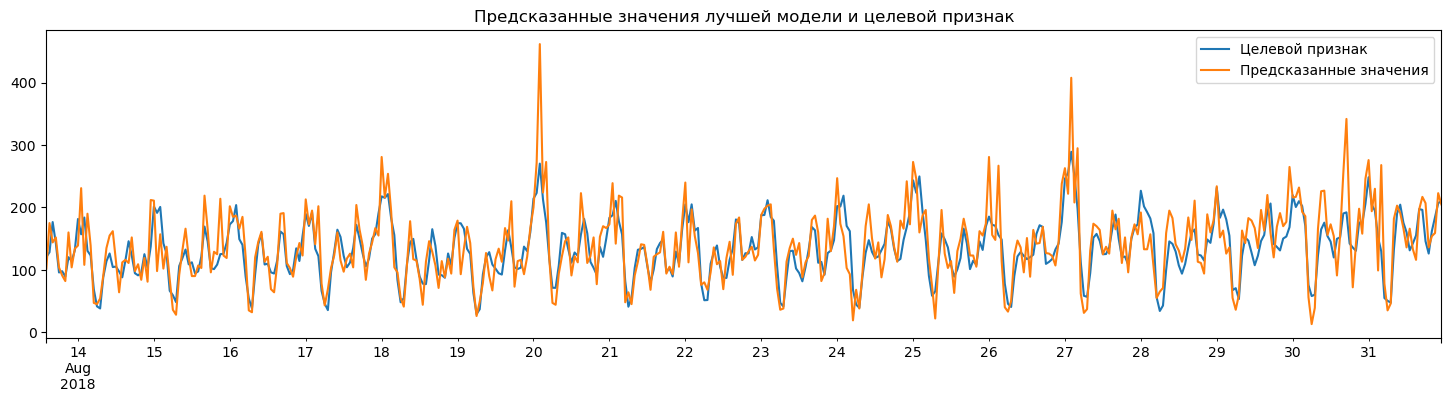

In [478]:
# Посмотрим на предсказанные значения лучшей модели и целевой признак
pd.Series(pred_lasso, index=test_target.index).plot()
test_target.plot()
plt.legend(['Целевой признак', 'Предсказанные значения'])
plt.title('Предсказанные значения лучшей модели и целевой признак')
plt.xlabel(None);

### Вывод:

В процессе выполнения анализа данных были сделаны следующие шаги: загрузка данных, визуализация данных в виде графиков, создание новых признаков, разделение данных на обучающую и тестовую выборки. Для проведения тестирования были выбраны модели Ridge, Lasso и LightGBM. Для оптимизации моделей был использован GridSearchCV для подбора гиперпараметров. Разделение выборки на фолды для кросс-валидации было выполнено с использованием TimeSeriesSplit из библиотеки sklearn, который последовательно увеличивает размер обучающей выборки и уменьшает размер валидационной выборки.

Подбор гиперпараметров и скользящая средняя имеют влияние на качество метрики. Основное улучшение метрики было достигнуто путем увеличения числа лагов.

Наилучшая метрика была получена от модели Lasso со значением RMSE = 34.954054013869445.